<a href="https://colab.research.google.com/github/SalmaKaiss-ui/DS/blob/main/Salma_Kaiss_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. IMPORTATION DES LIBRAIRIES



In [46]:
# ============================================================
# 📌 0. IMPORTATION DES LIBRAIRIES
# ============================================================

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. PRÉ-TRAITEMENT DES DONNÉES

In [47]:
# ============================================================
# 📌 1. CHARGEMENT DU DATASET
# ============================================================

df = pd.read_csv("https://raw.githubusercontent.com/SalmaKaiss-ui/Data-Science/main/Social%20media%20analysis/sentimentdataset.csv")

print("Aperçu du dataset :")
df.head()

Aperçu du dataset :


,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


1.1 Nettoyage : doublons & formats

In [48]:
# Nombre de lignes avant nettoyage
print("Nombre de lignes avant suppression des doublons:", df.shape)

# Suppression des doublons
df = df.drop_duplicates()

print("Nombre de lignes après nettoyage:", df.shape)

Nombre de lignes avant suppression des doublons: (732, 15)
Nombre de lignes après nettoyage: (732, 15)


1.2 Gestion des valeurs manquantes (imputation avancée)

In [49]:
# Vérification des valeurs manquantes
print("Valeurs manquantes :")
print(df.isnull().sum())

# Stratégie :
# - numériques : remplacer par la médiane (plus robuste)
# - catégorielles : remplacer par le mode

for col in df.columns:
    if df[col].dtype != "object":
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("Valeurs manquantes après imputation :")
print(df.isnull().sum())

Valeurs manquantes :
Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64
Valeurs manquantes après imputation :
Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64


1.3 Encodage des variables catégorielles + Normalisation

*  On encode la colonne cible Sentiment avec LabelEncoder (classique).
* Les colonnes catégorielles comme User, Platform, Country sont transformées avec One-Hot Encoding.
* Les colonnes numériques seront standardisées (StandardScaler).

In [50]:
# Colonne cible
label_encoder = LabelEncoder()
df["Sentiment_encoded"] = label_encoder.fit_transform(df["Sentiment"])

# Séparation X / y
y = df["Sentiment_encoded"]

# On enlève les colonnes textuelles inutiles pour le ML
X = df.drop(columns=["Sentiment", "Sentiment_encoded", "Text", "Timestamp", "User"])

# Séparation colonnes numériques / catégorielles
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Préprocesseur (one-hot + normalisation)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

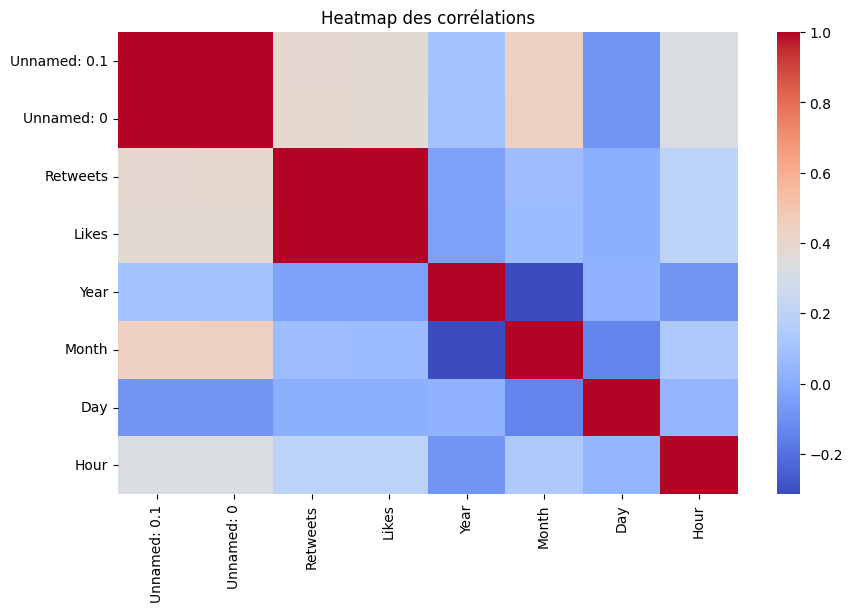

In [56]:
# ------------------------------------------------------------
# MATRICE DE CORRÉLATION
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_features].corr(), annot=False, cmap="coolwarm")
plt.title("Heatmap des corrélations")
plt.show()

# 2. ANALYSE EXPLORATOIRE (EDA)
2.1 Histogrammes des variables numériques

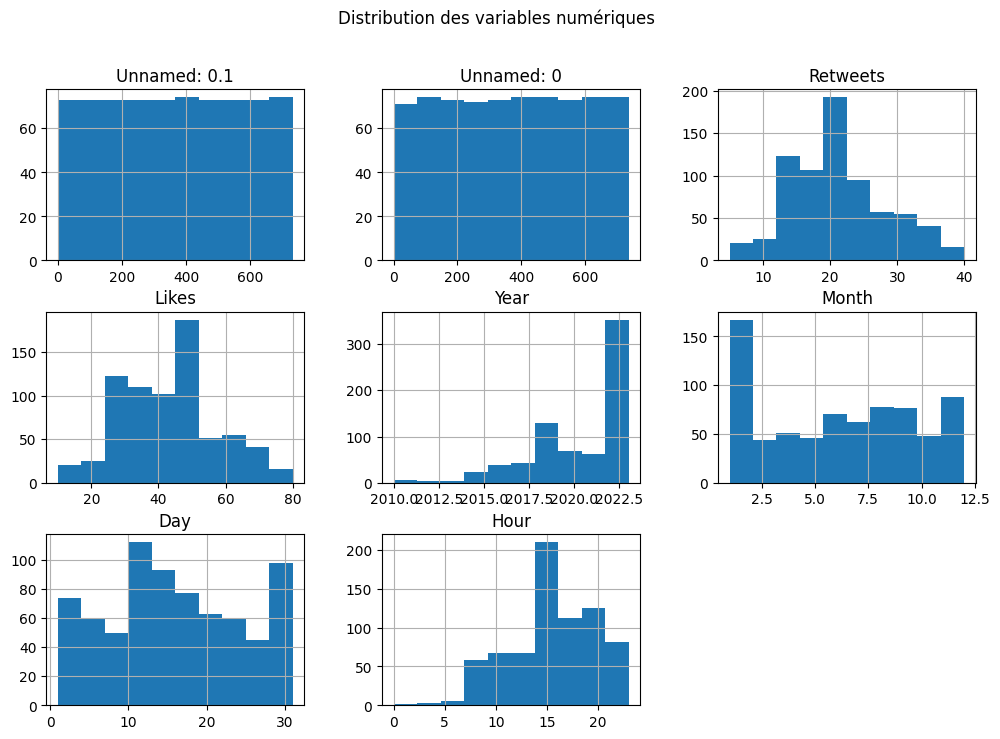

Interprétation :
- Les histogrammes montrent la répartition des likes, retweets, followers, etc.
- Cela permet d’identifier les variables déséquilibrées ou très étalées.


In [57]:
df[numeric_features].hist(figsize=(12, 8))
plt.suptitle("Distribution des variables numériques")
plt.show()

print("Interprétation :")
print("- Les histogrammes montrent la répartition des likes, retweets, followers, etc.")
print("- Cela permet d’identifier les variables déséquilibrées ou très étalées.")

2.2 Boxplots pour détecter les valeurs extrêmes

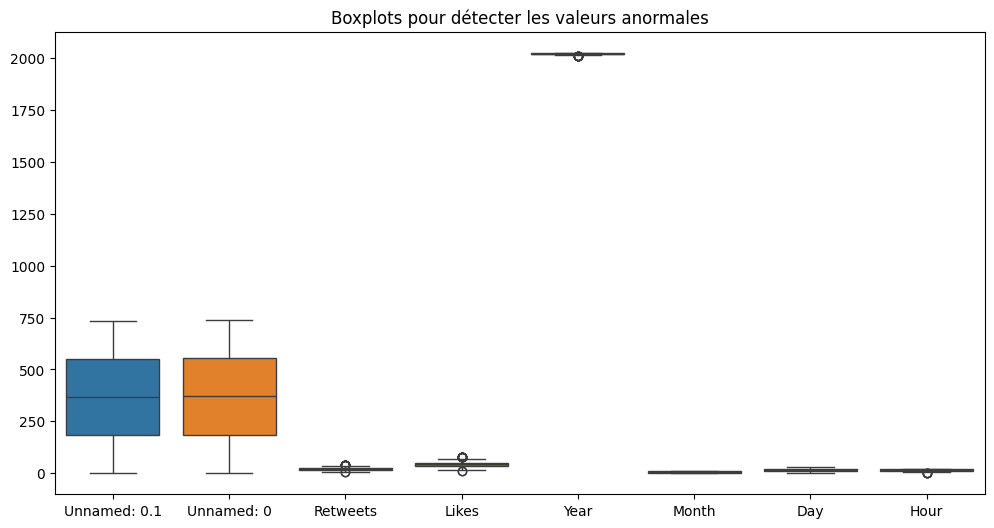

Interprétation :
- Les boxplots montrent des valeurs extrêmes (outliers).
- Les réseaux sociaux ont souvent des comptes très populaires, d’où des valeurs élevées.


In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_features])
plt.title("Boxplots pour détecter les valeurs anormales")
plt.show()

print("Interprétation :")
print("- Les boxplots montrent des valeurs extrêmes (outliers).")
print("- Les réseaux sociaux ont souvent des comptes très populaires, d’où des valeurs élevées.")

2.3 Heatmap des corrélations

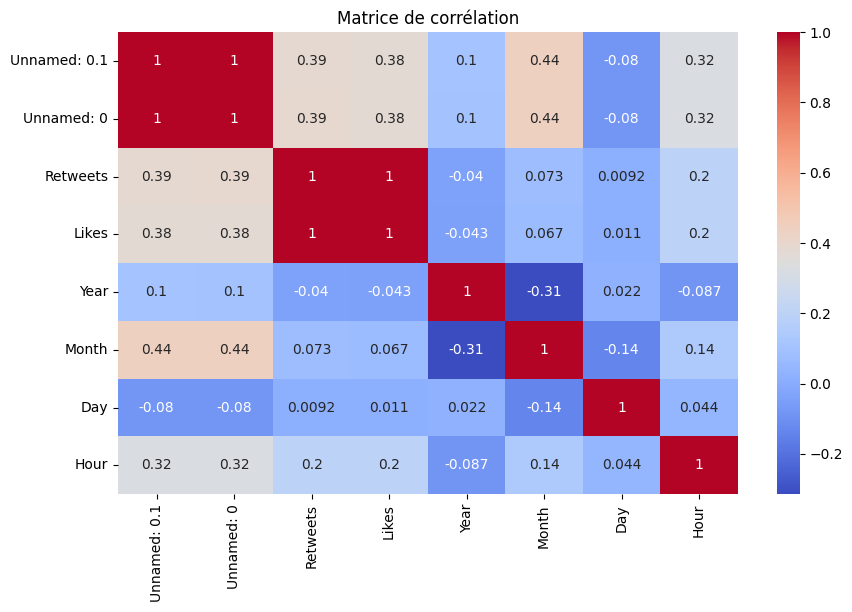

Interprétation :
- Permet d’identifier les variables fortement liées.
- Exemple : les utilisateurs avec beaucoup de followers ont souvent beaucoup de likes.


In [59]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

print("Interprétation :")
print("- Permet d’identifier les variables fortement liées.")
print("- Exemple : les utilisateurs avec beaucoup de followers ont souvent beaucoup de likes.")

2.4 Feature Engineering (création d’une nouvelle variable)

In [60]:
# Exemple : engagement = (likes + retweets)
df["Engagement_rate"] = df["Likes"] + df["Retweets"]

print("Nouvelle variable créée : Engagement_rate")
df["Engagement_rate"].head()

Nouvelle variable créée : Engagement_rate


,Engagement_rate
0,45.0
1,15.0
2,60.0
3,23.0
4,37.0


# 3. MODÉLISATION MACHINE LEARNING
 3.1 Séparation train/test

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

3.2 Définition des modèles

In [62]:
models = {
    "Régression Logistique": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

3.3 Entraînement + Cross-validation pour chaque modèle

In [53]:
for name, model in models.items():
    clf = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

    cv_scores = cross_val_score(clf, X, y, cv=5)

    print(f"\n📌 {name}")
    print("Score CV moyen :", cv_scores.mean().round(4))


📌 Régression Logistique
Score CV moyen : 0.2419

📌 Random Forest
Score CV moyen : 0.3362

📌 SVM
Score CV moyen : 0.1995


3.4 Évaluation finale sur le test set

In [54]:
best_model = RandomForestClassifier()  # modèle performant
clf = Pipeline(steps=[("preprocess", preprocessor), ("model", best_model)])
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Get the unique labels present in y_test
unique_labels_in_test = np.unique(y_test)
# Map these numerical labels back to their string names using the label_encoder
target_names_for_report = label_encoder.inverse_transform(unique_labels_in_test)

print("\n===== ÉVALUATION DU MODÈLE ====")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, labels=unique_labels_in_test, target_names=target_names_for_report))


===== ÉVALUATION DU MODÈLE ====
Accuracy : 0.272108843537415

Rapport de classification :
                        precision    recall  f1-score   support

         Acceptance          0.00      0.00      0.00         2
           Admiration        0.00      0.00      0.00         1
        Admiration           0.00      0.00      0.00         1
         Affection           1.00      1.00      1.00         1
      Ambivalence            0.00      0.00      0.00         1
         Anger               1.00      1.00      1.00         1
        Anticipation         0.00      0.00      0.00         1
        Arousal              0.00      0.00      0.00         3
                  Awe        0.00      0.00      0.00         1
         Awe                 0.00      0.00      0.00         1
                  Bad        0.00      0.00      0.00         1
             Betrayal        0.00      0.00      0.00         2
        Betrayal             0.00      0.00      0.00         1
         Bit

3.5 Optimisation des hyperparamètres (GridSearchCV)

In [63]:
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

grid = GridSearchCV(
    Pipeline([("preprocess", preprocessor), ("model", RandomForestClassifier())]),
    param_grid,
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("🔍 Meilleurs paramètres trouvés :", grid.best_params_)

y_pred_opt = grid.predict(X_test)

print("\nAccuracy après optimisation :", accuracy_score(y_test, y_pred_opt))


🔍 Meilleurs paramètres trouvés : {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}

Accuracy après optimisation : 0.2585034013605442
